In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import correlate
import math

Text(0, 0.5, 'Magnitude')

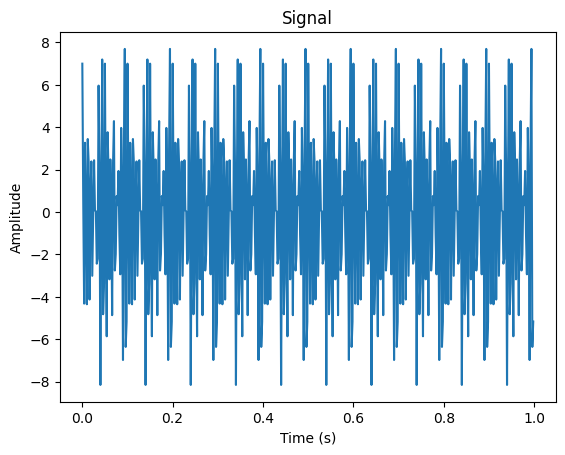

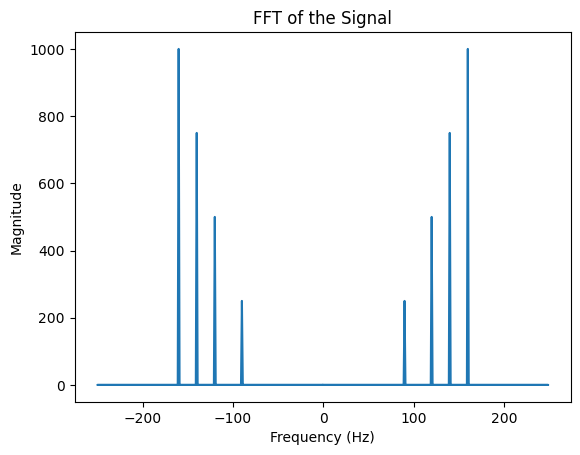

In [10]:
# Exercise 1
Fs = 500
Ts = 1 / Fs
t = np.arange(0, 1, Ts)
f1= 90
A1 = 1
f2 = 120
A2 = 2
f3 =140
A3 = 3
f4 = 160
A4 = 4
signal = (A1 * np.sin(2 * np.pi * f1 * t) + A2 * np.sin(2 * np.pi * f2 * t) +
          A3 * np.cos(2 * np.pi * f3 * t) + A4 * np.cos(2 * np.pi * f4 * t))

# Exercise 2
plt.figure()
plt.plot(t, signal)
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

N = len(signal)
fft_signal = fft(signal)
frequencies = np.fft.fftfreq(N, Ts)

plt.figure()
plt.plot(frequencies, np.abs(fft_signal))
plt.title('FFT of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

Text(0, 0.5, 'Magnitude')

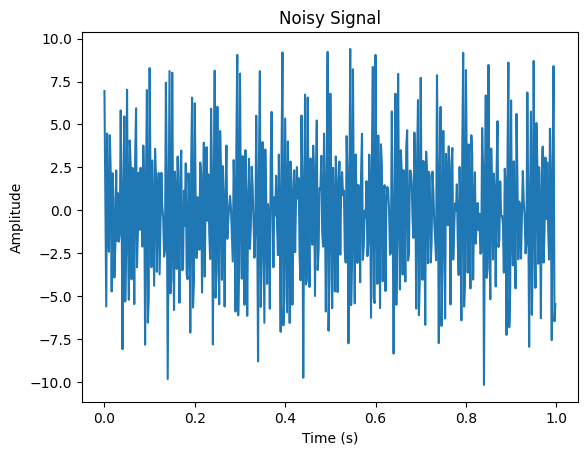

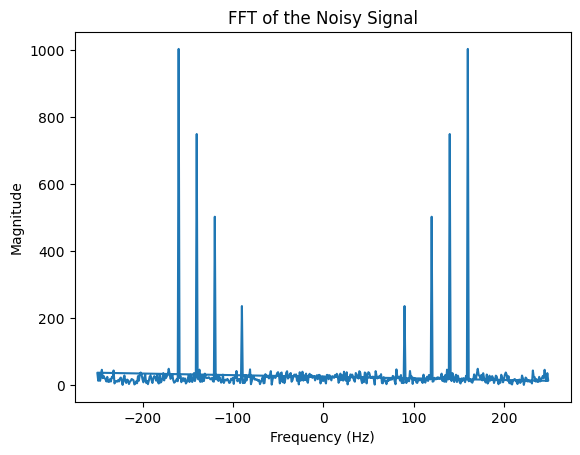

In [11]:
# Exercise 3
n_signal = signal + np.random.randn(len(signal))

plt.figure()
plt.plot(t, n_signal)
plt.title('Noisy Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

fft_n_signal = fft(n_signal)

plt.figure()
plt.plot(frequencies, np.abs(fft_n_signal))
plt.title('FFT of the Noisy Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

Text(0, 0.5, 'Amplitude')

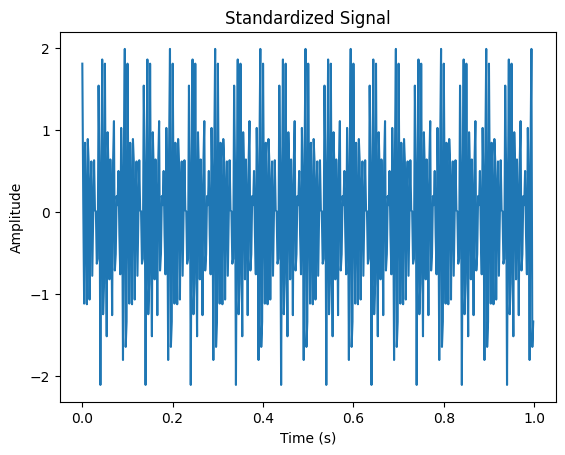

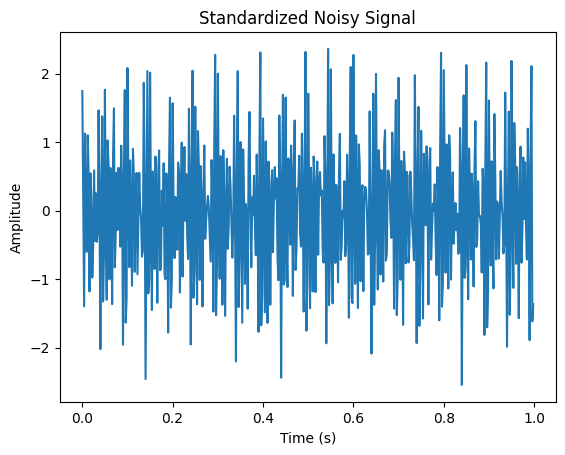

In [12]:
# Exercise 4
s_signal = (signal - np.mean(signal)) / np.std(signal)
s_noisy_signal = (n_signal - np.mean(n_signal)) / np.std(n_signal)

plt.figure()
plt.plot(t, s_signal)
plt.title('Standardized Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(t, s_noisy_signal)
plt.title('Standardized Noisy Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

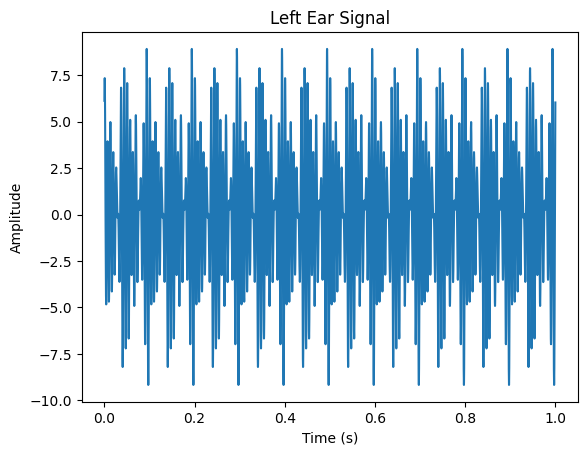

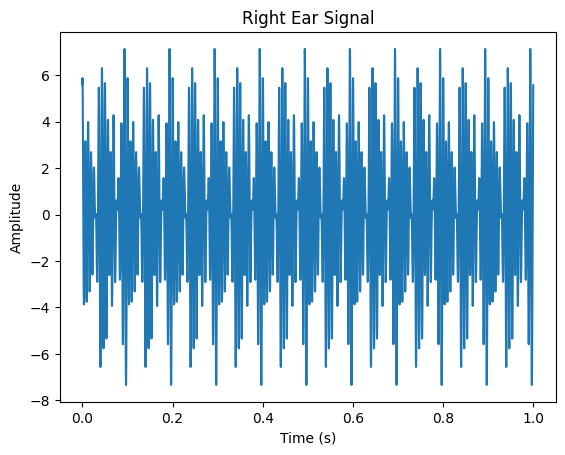

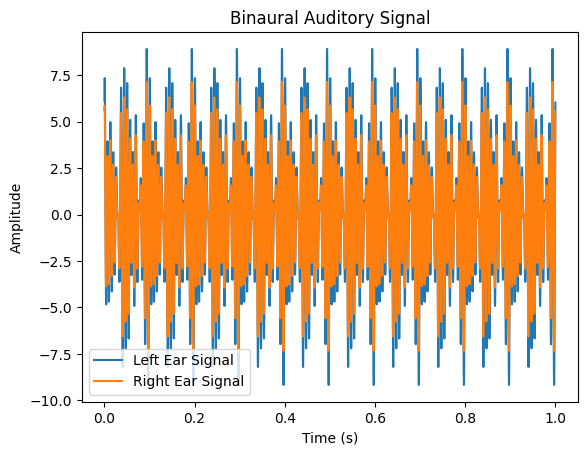

In [13]:
# Exercise 5
Fs_high = 44000
t_high = np.arange(0, 1, 1/Fs_high)
signal_high = (A1 * np.sin(2 * np.pi * f1 * t_high) + A2 * np.sin(2 * np.pi * f2 * t_high) +
               A3 * np.cos(2 * np.pi * f3 * t_high) + A4 * np.cos(2 * np.pi * f4 * t_high))

degree = 45
distance = 1
c = 346  # speed of sound in m/s
ear_distance = 0.15
time_delay = (ear_distance * np.sin(np.radians(degree))) / c
sample_delay = int(np.round(time_delay * Fs_high))

left_signal = np.roll(signal_high, sample_delay) / distance
right_signal = signal_high / distance * 0.8

binaural_signal = np.vstack((left_signal, right_signal)).T

plt.figure()
plt.plot(t_high, left_signal)
plt.title('Left Ear Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(t_high, right_signal)
plt.title('Right Ear Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.plot(t_high, left_signal, label='Left Ear Signal')
plt.plot(t_high, right_signal, label='Right Ear Signal')
plt.title('Binaural Auditory Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

In [14]:
# Exercise 6
correlation = correlate(left_signal, right_signal)
max_idx = np.argmax(correlation)
delay = max_idx - len(right_signal)
itd = delay / Fs_high

left_level = 20 * np.log10(np.sqrt(np.mean(left_signal ** 2)))
right_level = 20 * np.log10(np.sqrt(np.mean(right_signal ** 2)))
ild = left_level - right_level

print(f'Interaural Time Difference (ITD): {itd} seconds')
print(f'Interaural Level Difference (ILD): {ild} dB')

Interaural Time Difference (ITD): 0.00027272727272727274 seconds
Interaural Level Difference (ILD): 1.9382002601611266 dB


In [15]:
# Exercise 7
def erbspace(low_freq, high_freq, num_filters):
    EarQ = 9.26449
    minBW = 24.7
    erb_low = 21.4 * np.log10(1 + low_freq / (EarQ * minBW))
    erb_high = 21.4 * np.log10(1 + high_freq / (EarQ * minBW))
    erb_points = np.linspace(erb_low, erb_high, num_filters)
    return (10 ** (erb_points / 21.4) - 1) * (EarQ * minBW)

num_filters = 10
lower_freq = 100
upper_freq = 4000
center_frequencies = erbspace(lower_freq, upper_freq, num_filters)

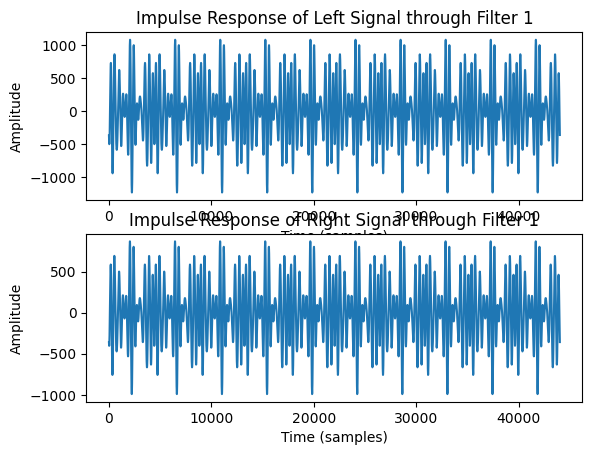

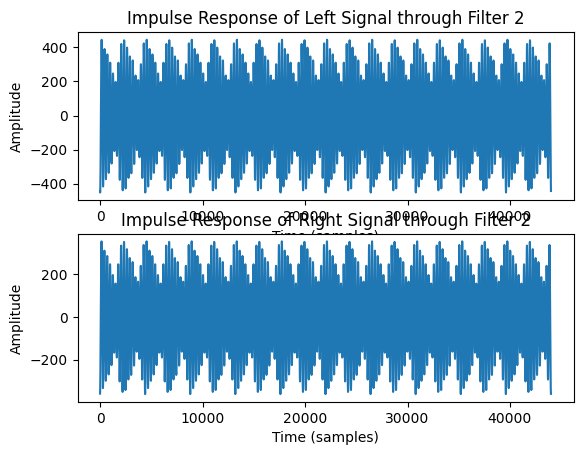

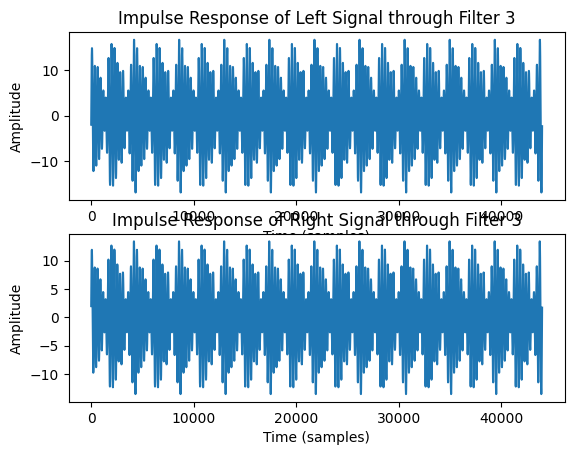

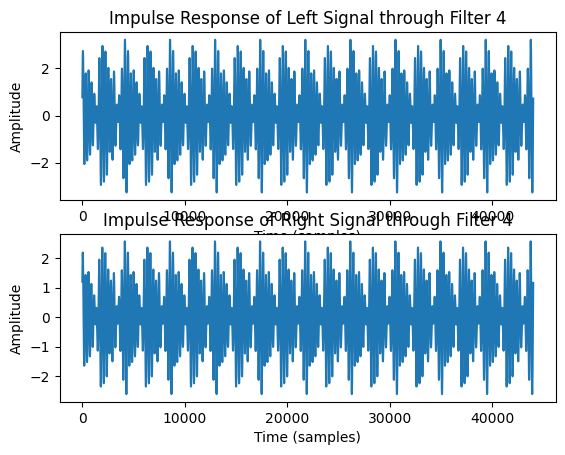

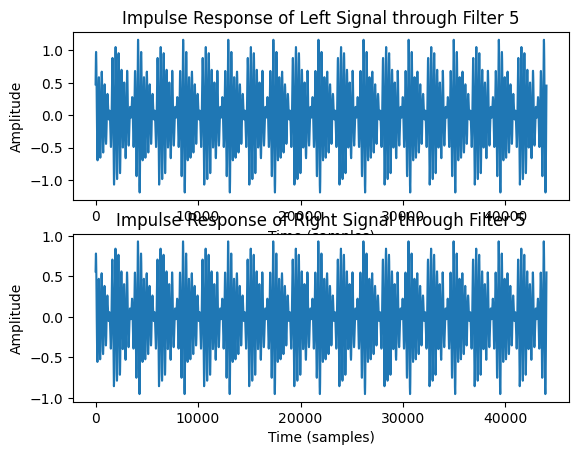

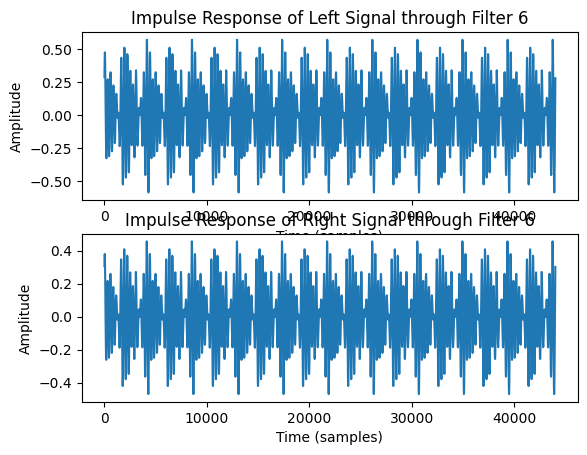

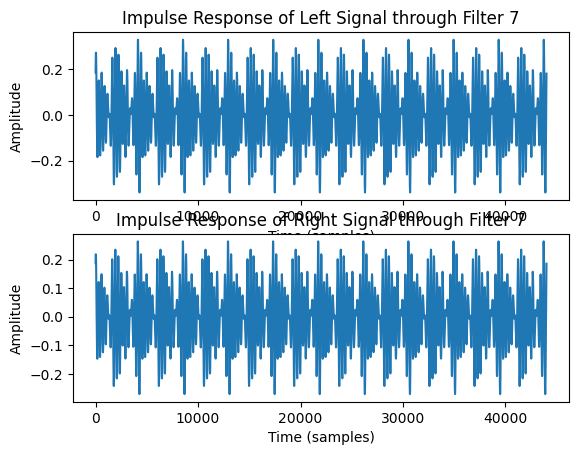

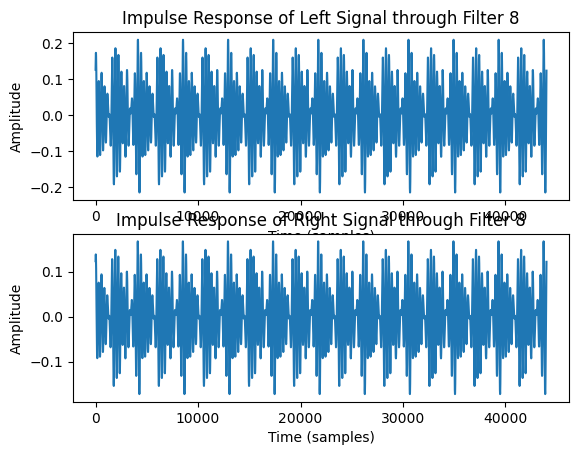

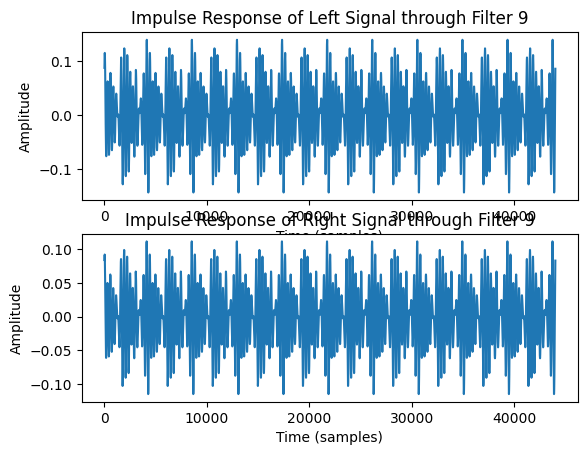

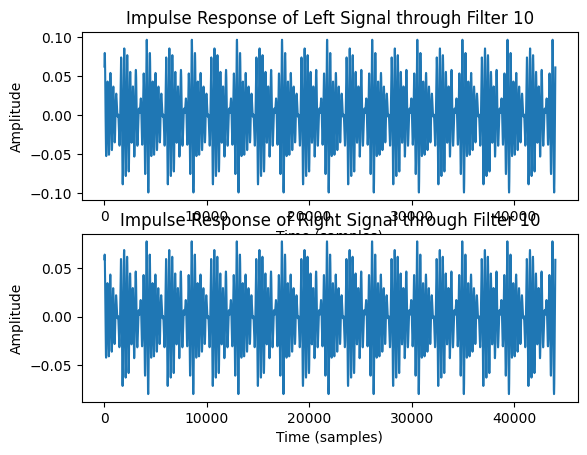

In [16]:
# Exercise 8
def gammatone_filter(fc, fs, duration):
    t = np.arange(0, duration, 1/fs)
    a = 1.019
    erb = 24.7 * (4.37 * fc / 1000 + 1)
    b = a * erb
    gt = t**3 * np.exp(2 * np.pi * 1j * fc * t) * np.exp(-2 * np.pi * b * t)
    return gt / np.max(np.abs(gt))

def gammatone_filter_bank(signal, center_frequencies, fs):
    num_filters = len(center_frequencies)
    N = len(signal)
    duration = N / fs
    filtered_signal = np.zeros((num_filters, N))
    for i, fc in enumerate(center_frequencies):
        gt = gammatone_filter(fc, fs, duration)
        filtered_signal[i, :] = np.real(np.fft.ifft(np.fft.fft(signal) * np.fft.fft(gt, N)))
    return filtered_signal

filtered_left_signal = gammatone_filter_bank(left_signal, center_frequencies, Fs_high)
filtered_right_signal = gammatone_filter_bank(right_signal, center_frequencies, Fs_high)

for i in range(num_filters):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(filtered_left_signal[i, :])
    plt.title(f'Impulse Response of Left Signal through Filter {i+1}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(filtered_right_signal[i, :])
    plt.title(f'Impulse Response of Right Signal through Filter {i+1}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

plt.show()